In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster
import shap

In [3]:
deposit_data = pd.read_csv("../../Curated_data/final_dataset.csv", low_memory=False)


In [5]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_6393,phi_6394,phi_6395,phi_6396,phi_6397,phi_6398,phi_6399,phi_6400,phi_6401,phi_6402
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.8800,0.127305,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.8800,0.160479,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.9900,0.128743,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,0.9900,0.141317,0.375,0.133333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,0.9900,0.153293,0.500,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,0.9235,0.078443,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,0.9235,0.074850,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,0.8584,0.076647,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,0.8584,0.077246,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[1:4].tolist()

# Display the list of column names
print(phi_columns[-1])


Z


In [38]:
phi_columns

['X', 'Y', 'Z']

In [34]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm', 'Random_Values'] 

covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 

In [35]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

In [36]:
p = len(phi_columns) + len(covariates)

In [37]:
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

In [21]:
deposit_data[phi_columns + covariates]

,X,Y,Z,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
0,0.437814,0.509816,0.461455,0.250,0.066667,0.0,0.8800,0.127305
1,0.438061,0.509789,0.460591,0.250,0.066667,0.0,0.8800,0.160479
2,0.448174,0.508800,0.426068,0.250,0.066667,0.0,0.9900,0.128743
3,0.448431,0.508777,0.425204,0.375,0.133333,0.0,0.9900,0.141317
4,0.448683,0.508755,0.424340,0.500,0.200000,0.0,0.9900,0.153293
...,...,...,...,...,...,...,...,...
2613,0.629186,0.001755,0.432766,0.050,0.200000,0.0,0.9235,0.078443
2614,0.629096,0.001314,0.431988,0.050,0.200000,0.0,0.9235,0.074850
2615,0.629011,0.000877,0.431205,0.050,0.200000,0.0,0.8584,0.076647
2616,0.628921,0.000436,0.430427,0.050,0.200000,0.0,0.8584,0.077246


# Deepkriging train test split

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = deposit_data.columns[1:4].tolist()

torch.manual_seed(42)
np.random.seed(42)

p = len(phi_columns) + len(covariates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(deposit_data[phi_columns + covariates],
                                                    deposit_data['Density_gcm3'],
                                                    test_size=0.3, random_state=42)

# Define the neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

# Training loop
for step in range(601):
    pre = model(torch.tensor(X_train.values, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


torch.manual_seed(42)
np.random.seed(42)
# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test")



Metrics for Test set:
  MSE: 0.0119
  RMSE: 0.1091
  MAE: 0.0718
  R^2: 0.1878



In [40]:
covariates = phi_columns + covariates

In [41]:
covariates

['X', 'Y', 'Z', 'CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

# Combinations for the rest of the features

In [45]:
import pandas as pd
from itertools import combinations

X_CP_Total = X_test[['CP_Total']]
selected_columns = [col for col in X_test.columns if col != 'CP_Total']
X_CP_Total_c = X_test[selected_columns]

new_dataframes_CP_Total = []
Q = []
new_dataframes_CP_Total.append(pd.concat([X_CP_Total_c.copy(), X_CP_Total], axis=1))

numcovar = len(covariates)
#covariates 

Q.append(numcovar)

for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total.append(pd.concat([new_df, X_CP_Total], axis=1))


new_dataframes_CP_Total_aux = new_dataframes_CP_Total

# Assuming X_CP_Total_c is your existing DataFrame and X_CP_Total is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
new_dataframes_CP_Total_0 = []

# Create a DataFrame with all columns in X_CP_Total set to 0
zero_X_CP = pd.DataFrame(0, index=X_CP_Total.index, columns=X_CP_Total.columns)

new_dataframes_CP_Total_0.append(pd.concat([X_CP_Total_c.copy(), zero_X_CP], axis=1))


for r in range(1, len(X_CP_Total_c.columns) + 1):
    for combo in combinations(X_CP_Total_c.columns, r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total_0.append(pd.concat([new_df, zero_X_CP], axis=1))
        n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



result_list = [x - 1 for x in Q]
Q = Q + result_list


all_subgroups_CP_Total = new_dataframes_CP_Total + new_dataframes_CP_Total_0
len(all_subgroups_CP_Total)

256

In [58]:
all_subgroups_CP_Total[8]

,X,Y,Z,PO_Total,PY_Total,RQD_Pct,Cr_ppm,CP_Total
2240,0,0,0.414011,0.020000,0.00,0.9930,0.144910,0.050
175,0,0,0.413759,0.133333,0.00,0.9900,0.245509,0.250
1253,0,0,0.328224,0.000000,0.00,0.9804,0.109581,0.925
1461,0,0,0.478433,0.020000,0.00,0.9698,0.076048,0.025
2430,0,0,0.494727,0.013333,0.08,0.9351,0.904192,0.000
...,...,...,...,...,...,...,...,...
999,0,0,0.370683,0.133333,0.20,0.9400,0.202395,0.000
1505,0,0,0.396542,0.026667,0.00,0.9984,0.376347,0.025
1061,0,0,0.262201,0.133333,0.00,0.9800,0.065120,0.500
1953,0,0,0.312128,0.066667,0.00,1.0000,0.569162,0.075


In [44]:
X_CP_Total_c

,X,Y,Z,PO_Total,PY_Total,RQD_Pct,Cr_ppm
2240,0.432015,0.485334,0.414011,0.020000,0.00,0.9930,0.144910
175,0.453501,0.821841,0.413759,0.133333,0.00,0.9900,0.245509
1253,0.565907,0.240157,0.328224,0.000000,0.00,0.9804,0.109581
1461,0.707851,0.600727,0.478433,0.020000,0.00,0.9698,0.076048
2430,0.512160,0.122613,0.494727,0.013333,0.08,0.9351,0.904192
...,...,...,...,...,...,...,...
999,0.589943,0.993580,0.370683,0.133333,0.20,0.9400,0.202395
1505,0.746954,0.604528,0.396542,0.026667,0.00,0.9984,0.376347
1061,0.302406,0.697603,0.262201,0.133333,0.00,0.9800,0.065120
1953,0.611704,0.371066,0.312128,0.066667,0.00,1.0000,0.569162


In [14]:
Q

[5,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 4,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 0]

In [59]:
import pandas as pd
from itertools import combinations

# Create all possible combinations of columns and generate a new DataFrame for each combination
def subgroups(column):

# Column of interest
    X_column = X_test[[column]]

# Select all other columns
    selected_columns = [col for col in X_test.columns if col != column]
    X_column_c = X_test[selected_columns]

# Covariates + phi - active variable
    size = len(covariates) - 1

    numcovar = len(covariates) - 1
############### Phase 1: create all combinations of the data WITH the column of interest's original values ###############
    
    new_dataframes_column = []

# The first dataframe is all columns are active
    new_dataframes_column.append(pd.concat([X_column_c.copy(), X_column], axis=1))

# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column.append(pd.concat([new_df, X_column], axis=1))



############### Phase 2: create all combinations of the data WITHOUT the column of interest original values (set to 0) ###############


    new_dataframes_column_0 = []

# Create a DataFrame with all values in X_column set to 0
    zero_X_CP = pd.DataFrame(0, index=X_column.index, columns=X_column.columns)

#The first dataframe is all columns active but the one of interest
    new_dataframes_column_0.append(pd.concat([X_column_c.copy(), zero_X_CP], axis=1))

# Amount of active variables for each dataframe
    Q = []

# First dataframe is all active but one 
    Q.append(size)
    
# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column_0.append(pd.concat([new_df, zero_X_CP], axis=1))
            n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
            Q.append(n_features)



# Appending the number of active variables of the second loop, which has one less because phi cols are inactive
    result_list = [x - 1 for x in Q]
    Q = Q + result_list

    sorted_dfs1 = [df[X_test.columns] for df in new_dataframes_column]
    sorted_dfs2 = [df[X_test.columns] for df in new_dataframes_column_0]

    return sorted_dfs1, sorted_dfs2, Q

In [61]:
X_test

,X,Y,Z,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
2240,0.432015,0.485334,0.414011,0.050,0.020000,0.00,0.9930,0.144910
175,0.453501,0.821841,0.413759,0.250,0.133333,0.00,0.9900,0.245509
1253,0.565907,0.240157,0.328224,0.925,0.000000,0.00,0.9804,0.109581
1461,0.707851,0.600727,0.478433,0.025,0.020000,0.00,0.9698,0.076048
2430,0.512160,0.122613,0.494727,0.000,0.013333,0.08,0.9351,0.904192
...,...,...,...,...,...,...,...,...
999,0.589943,0.993580,0.370683,0.000,0.133333,0.20,0.9400,0.202395
1505,0.746954,0.604528,0.396542,0.025,0.026667,0.00,0.9984,0.376347
1061,0.302406,0.697603,0.262201,0.500,0.133333,0.00,0.9800,0.065120
1953,0.611704,0.371066,0.312128,0.075,0.066667,0.00,1.0000,0.569162


In [62]:
for col in X_test.columns.tolist():
    exec(f"permutations_{col}, permutations_{col}_0, Q_{col} = subgroups('{col}')")

In [137]:
permutations_CP_Total[10]

,X,Y,Z,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
2240,0,0.485334,0.414011,0.050,0,0.00,0.9930,0.144910
175,0,0.821841,0.413759,0.250,0,0.00,0.9900,0.245509
1253,0,0.240157,0.328224,0.925,0,0.00,0.9804,0.109581
1461,0,0.600727,0.478433,0.025,0,0.00,0.9698,0.076048
2430,0,0.122613,0.494727,0.000,0,0.08,0.9351,0.904192
...,...,...,...,...,...,...,...,...
999,0,0.993580,0.370683,0.000,0,0.20,0.9400,0.202395
1505,0,0.604528,0.396542,0.025,0,0.00,0.9984,0.376347
1061,0,0.697603,0.262201,0.500,0,0.00,0.9800,0.065120
1953,0,0.371066,0.312128,0.075,0,0.00,1.0000,0.569162


In [63]:
import math
psi_CP_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_CP_Total)):
               Q_c = model(torch.tensor(permutations_CP_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_CP_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_CP_Total[i])*math.factorial(S_abs - Q_CP_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_CP_Total = psi_CP_Total + summand

In [82]:
psi_PY_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PY_Total)):
               Q_c = model(torch.tensor(permutations_PY_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PY_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PY_Total[i])*math.factorial(S_abs - Q_PY_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PY_Total = psi_PY_Total + summand

In [83]:
psi_PO_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PO_Total)):
               Q_c = model(torch.tensor(permutations_PO_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PO_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PO_Total[i])*math.factorial(S_abs - Q_PO_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PO_Total = psi_PO_Total + summand

In [84]:
psi_RQD_Pct = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_RQD_Pct)):
               Q_c = model(torch.tensor(permutations_RQD_Pct_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_RQD_Pct[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_RQD_Pct[i])*math.factorial(S_abs - Q_RQD_Pct[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_RQD_Pct = psi_RQD_Pct + summand

In [85]:
psi_Cr_ppm = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Cr_ppm)):
               Q_c = model(torch.tensor(permutations_Cr_ppm_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Cr_ppm[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Cr_ppm[i])*math.factorial(S_abs - Q_Cr_ppm[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Cr_ppm = psi_Cr_ppm + summand

In [87]:
psi_X = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_X)):
               Q_c = model(torch.tensor(permutations_X_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_X[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_X[i])*math.factorial(S_abs - Q_X[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_X = psi_X + summand

In [88]:
psi_Y = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Y)):
               Q_c = model(torch.tensor(permutations_Y_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Y[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Y[i])*math.factorial(S_abs - Q_Y[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Y = psi_Y + summand

In [89]:
psi_Z = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Z)):
               Q_c = model(torch.tensor(permutations_Z_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Z[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Z[i])*math.factorial(S_abs - Q_Z[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Z = psi_Z + summand

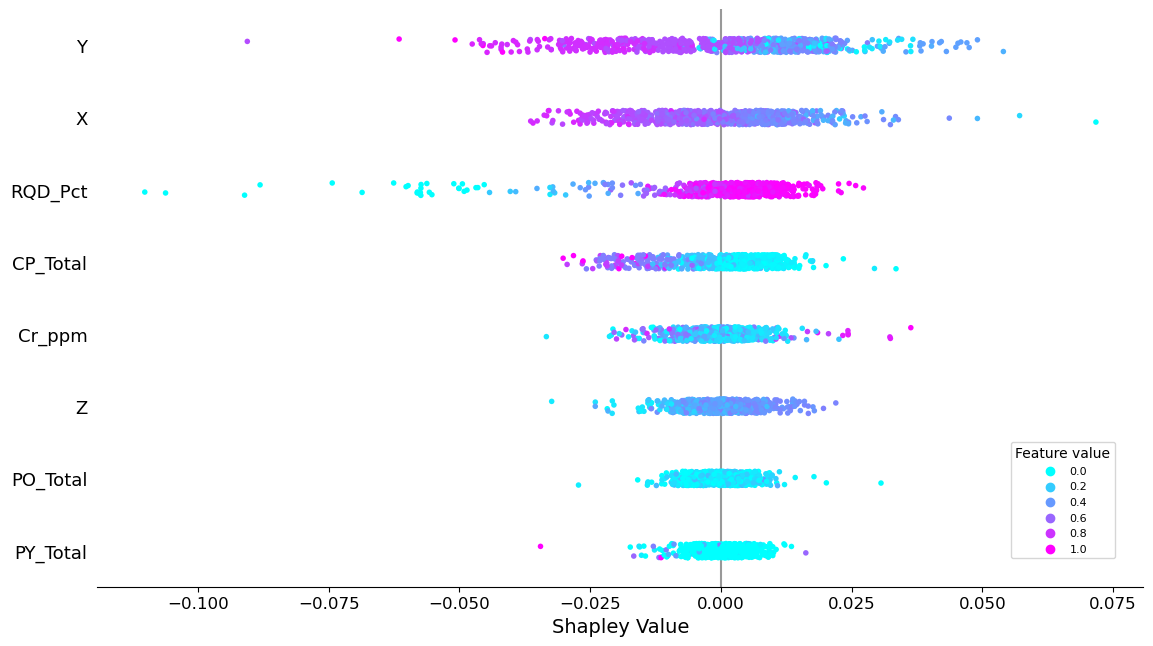

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Create DataFrames for the beeswarm plot
df_sv = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'X', 'Y', 'Z']



# Custom colormap
custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

# Populate the DataFrame with features, shapley values, and hue values
df_sv['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_X, psi_Y, psi_Z])
df_sv['hue'] = np.concatenate([X_test[feature].values for feature in features])




# Calculate the absolute sum of Shapley values for each feature
abs_sum_shapley = df_sv.groupby('feature')['shapley value'].apply(lambda x: np.sum(np.abs(x)))
feature_order = abs_sum_shapley.sort_values(ascending=False).index

# Sort the DataFrame based on the feature order
df_sv['feature'] = pd.Categorical(df_sv['feature'], categories=feature_order, ordered=True)
df_sv = df_sv.sort_values('feature')

# Beeswarm plot with custom colors
fig, ax = plt.subplots(figsize=(13.5, 7.5))  # Set the figure size (width, height)
ax.axvline(0, c="grey", alpha=0.8, linewidth=1.5)
sns.stripplot(
    x=df_sv['shapley value'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette=custom_cmap,
    size=4,
    linewidth=0  # Set linewidth for edges
)
ax.spines.left.set_visible(False)
ax.set_ylabel("")

#ax.set_yticklabels([r'$\phi$ (spatial comp)', 'Chromium (ppm)', 'Pyrrhotite (%)', 'Chalcopyrite (%)', 'Rock Quality (% intact) ', 'Pyrite (%)'])


# Increase x-axis and y-axis tick font size
ax.tick_params(axis='x', labelsize=12)  # Adjust the labelsize as needed
ax.tick_params(axis='y', labelsize=13)  # Adjust the labelsize as needed
ax.set_xlabel("Shapley Value", fontsize=14)

# Increase overall legend font size
legend = plt.legend(title='Feature value', loc='upper right', bbox_to_anchor=(0.978, 0.26), borderaxespad=0.5, fontsize='8')
legend.get_title().set_fontsize('10') 
ax.spines.right.set_visible(False)  # Remove the right spine
ax.spines.top.set_visible(False)    # Remove the top spine
ax.tick_params(left=False, bottom=True)

plt.show()


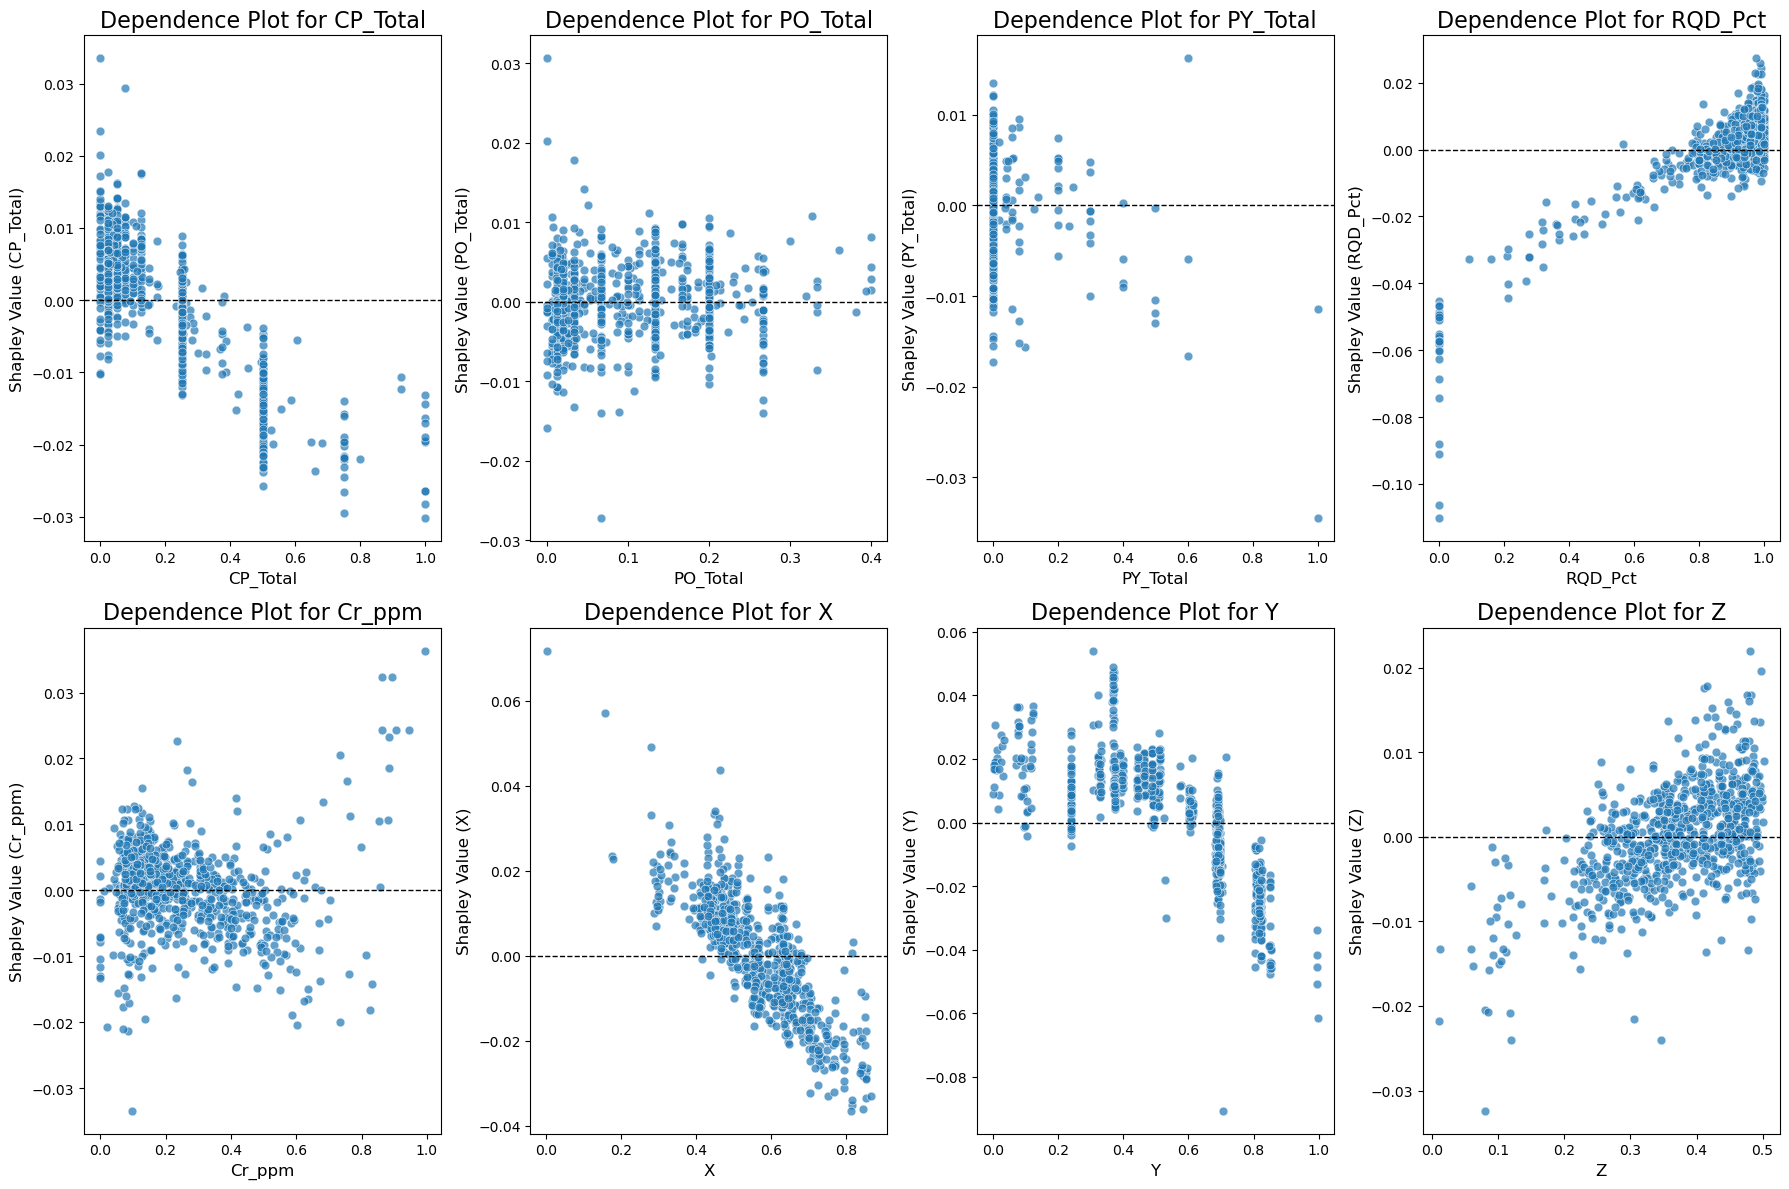

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, X_test, psi_X, psi_Y, psi_Z are your variables and DataFrame
# Replace these with your actual data

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'X', 'Y', 'Z']

# Create a subplot for each feature
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Scatter plot for dependence
    sns.scatterplot(x=X_test[feature], y=eval(f'psi_{feature}'), ax=axes[i], s=40, alpha=0.7)
    
    # Set plot title and labels
    axes[i].set_title(f'Dependence Plot for {feature}', fontsize=16)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel(f'Shapley Value ({feature})', fontsize=12)
    
    # Add a horizontal line at y=0 for reference
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [118]:
custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)


# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'X', 'Y', 'Z']



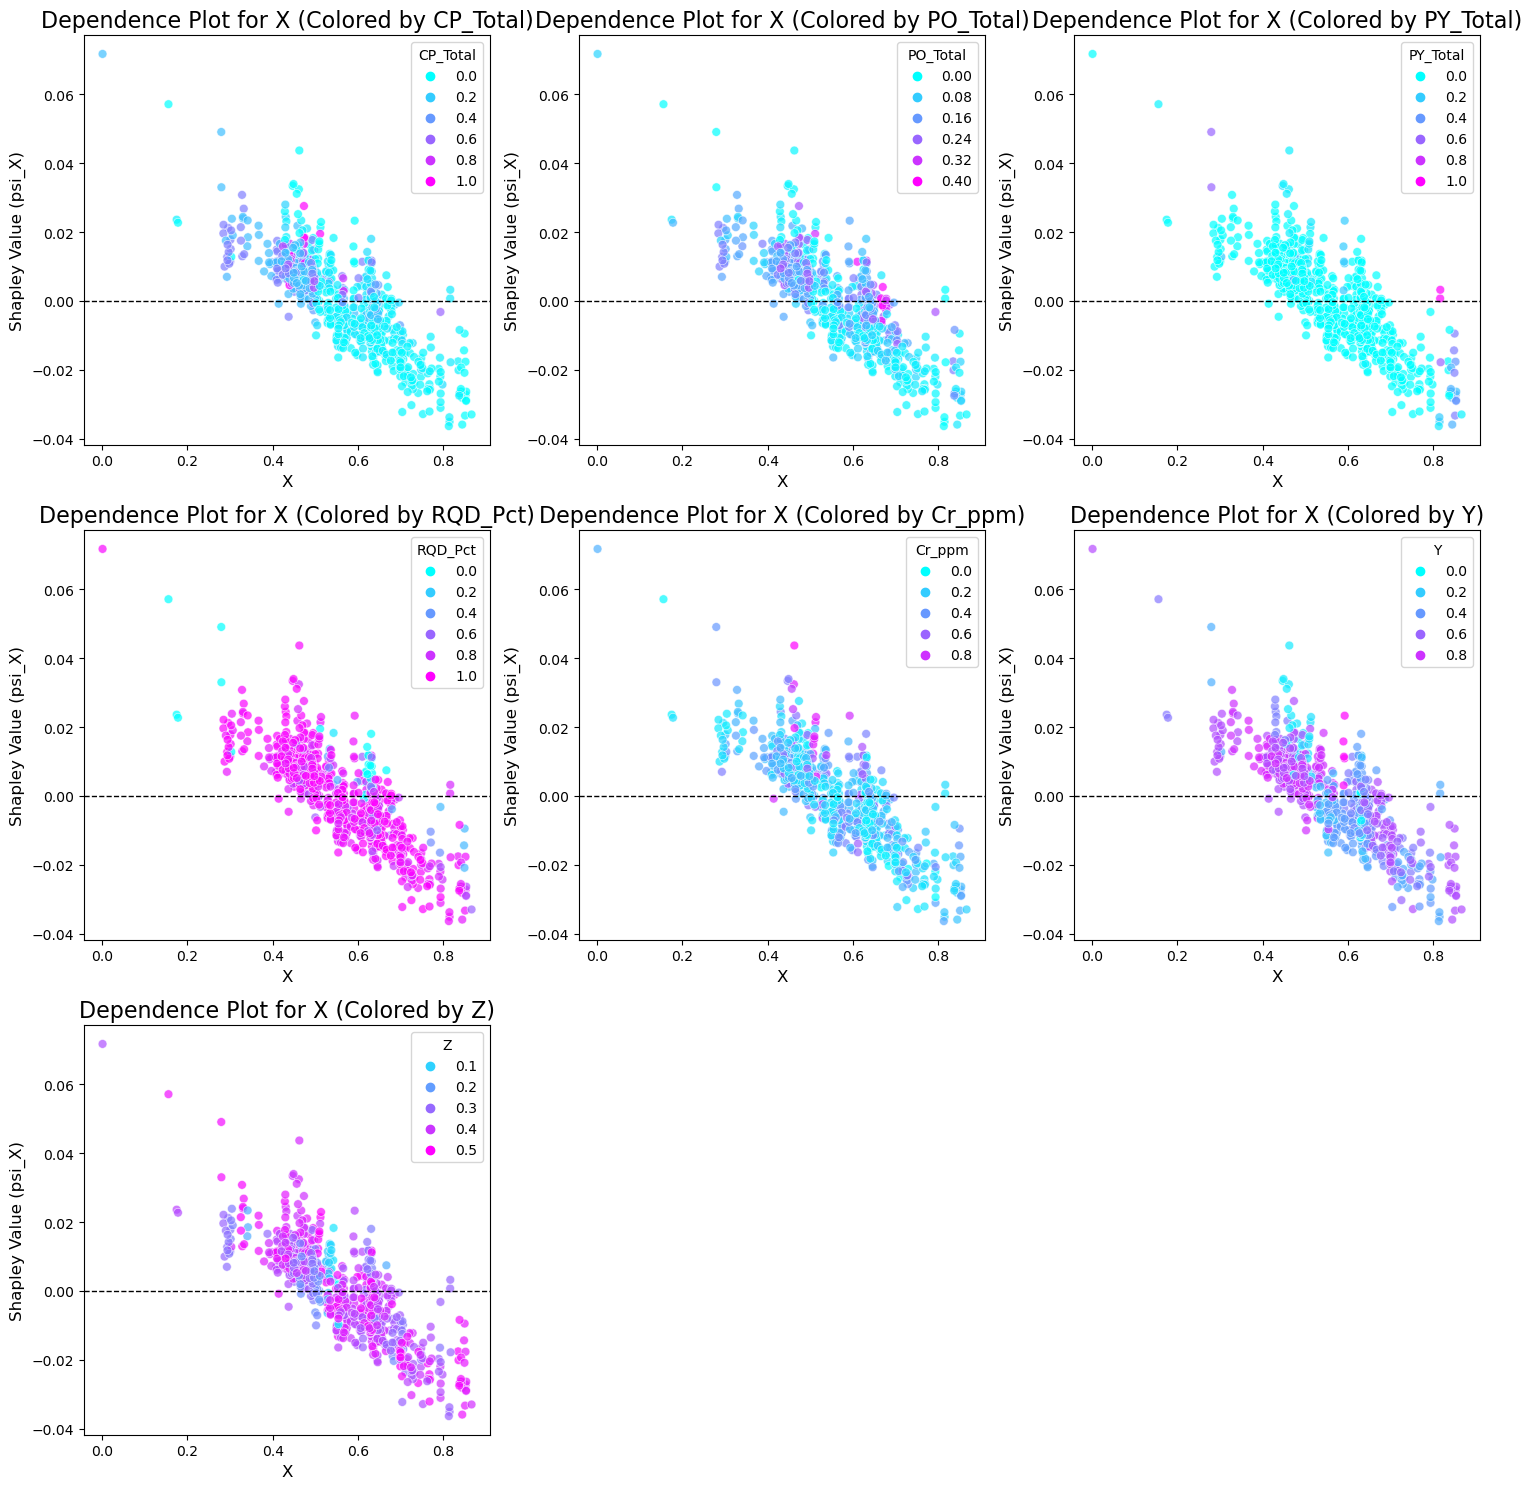

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_X, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'X', 'Y', 'Z']

features.remove('X')

# Create a subplot for each feature
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Iterate over the remaining features
for i, hue_feature in enumerate(features[:8]):  # Limit to the first 8 features
    # Scatter plot for X dependence colored with the value of the current hue_feature
    sns.scatterplot(x=X_test['X'], y=eval(f'psi_X'), hue=X_test[hue_feature], ax=axes[i],
                    palette=custom_cmap, s=40, alpha=0.7)
    
    # Set plot title and labels
    axes[i].set_title(f'Dependence Plot for X (Colored by {hue_feature})', fontsize=16)
    axes[i].set_xlabel('X', fontsize=12)
    axes[i].set_ylabel('Shapley Value (psi_X)', fontsize=12)
    
    # Add a horizontal line at y=0 for reference
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)

# Remove empty subplots in the last row
for i in range(len(features[:8]), 9):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [152]:
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']


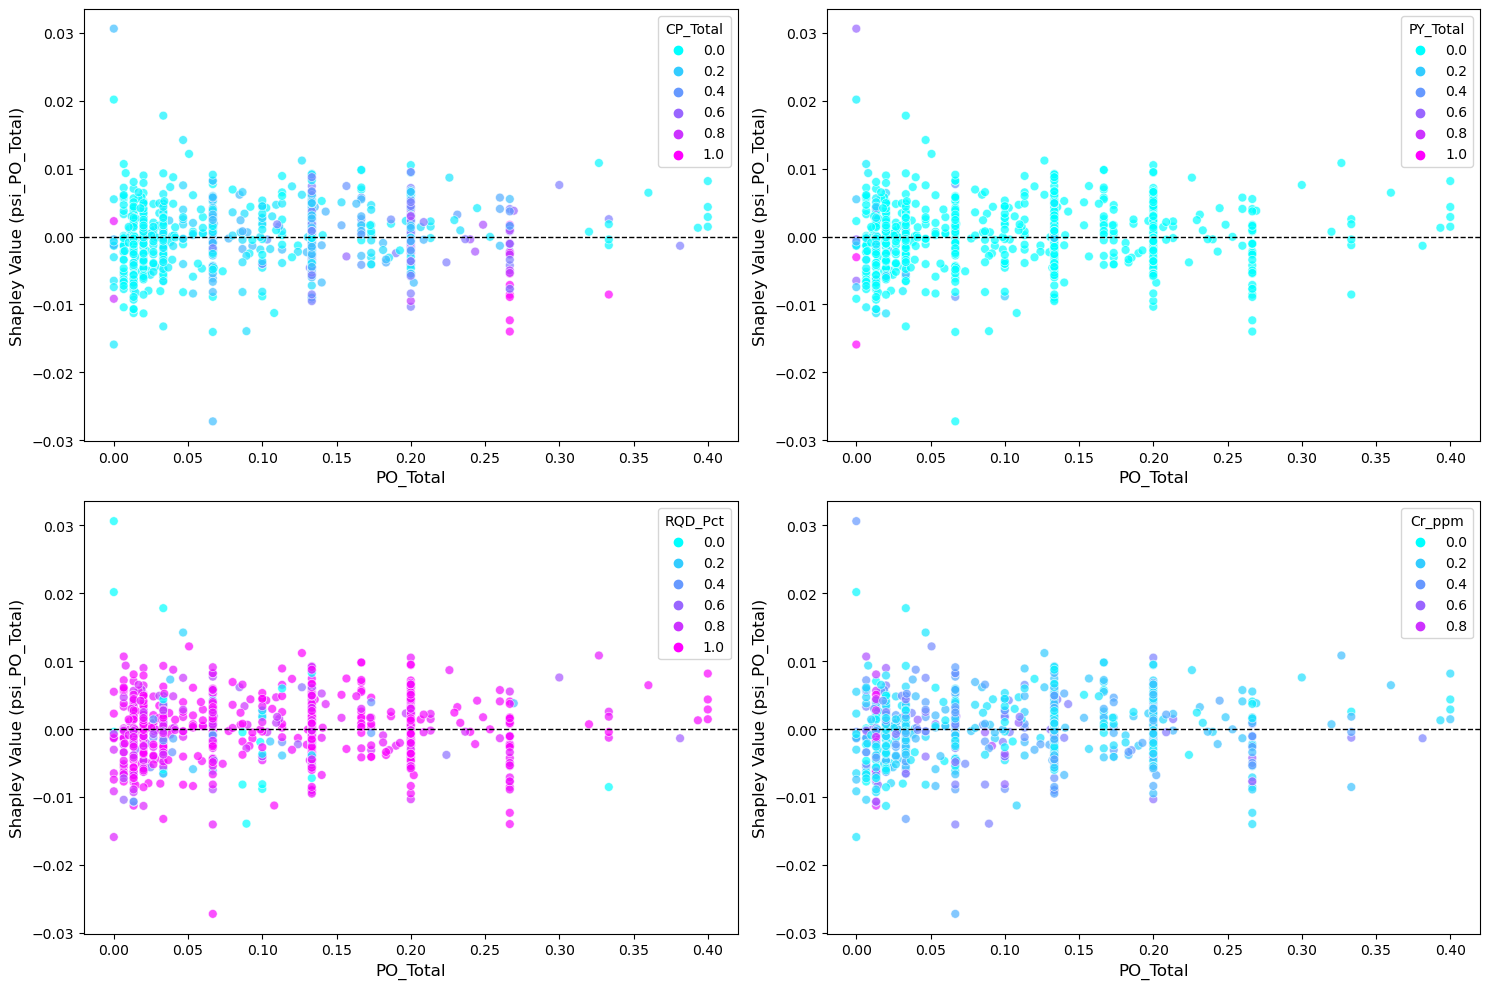

In [154]:

custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

features.remove('PO_Total')


# List of features

# Create a subplot for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()


color_palette = sns.color_palette("RdBu_r", as_cmap=True)

# Iterate over the remaining features
for i, hue_feature in enumerate(features):
    # Scatter plot for PO_Total dependence colored with the value of the current hue_feature
    sns.scatterplot(x=X_test['PO_Total'], y=psi_PO_Total, hue=X_test[hue_feature], ax=axes[i],
                    palette=custom_cmap, s=40, alpha=0.7)
    
    # Set plot title and labels
    axes[i].set_xlabel('PO_Total', fontsize=12)
    axes[i].set_ylabel('Shapley Value (psi_PO_Total)', fontsize=12)
    
    # Add a horizontal line at y=0 for reference
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()



In [126]:
X_test

,X,Y,Z,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
2240,0.432015,0.485334,0.414011,0.050,0.020000,0.00,0.9930,0.144910
175,0.453501,0.821841,0.413759,0.250,0.133333,0.00,0.9900,0.245509
1253,0.565907,0.240157,0.328224,0.925,0.000000,0.00,0.9804,0.109581
1461,0.707851,0.600727,0.478433,0.025,0.020000,0.00,0.9698,0.076048
2430,0.512160,0.122613,0.494727,0.000,0.013333,0.08,0.9351,0.904192
...,...,...,...,...,...,...,...,...
999,0.589943,0.993580,0.370683,0.000,0.133333,0.20,0.9400,0.202395
1505,0.746954,0.604528,0.396542,0.025,0.026667,0.00,0.9984,0.376347
1061,0.302406,0.697603,0.262201,0.500,0.133333,0.00,0.9800,0.065120
1953,0.611704,0.371066,0.312128,0.075,0.066667,0.00,1.0000,0.569162


In [29]:
import plotly.graph_objects as go
import pandas as pd

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Select a specific row (instance) from your dataset
instance_idx = 11  # Replace with the index of the instance you want to visualize
instance_row = X_test.iloc[instance_idx]

# Create a combined DataFrame for the waterfall plot
df_waterfall_combined = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi']

# Populate the DataFrame with features, shapley values, and hue values
df_waterfall_combined['feature'] = features
df_waterfall_combined['shapley value'] = [
    psi_CP_Total[instance_idx],
    psi_PO_Total[instance_idx],
    psi_PY_Total[instance_idx],
    psi_RQD_Pct[instance_idx],
    psi_Cr_ppm[instance_idx],
    psi_phi[instance_idx]  # Include phi in the same DataFrame
]
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

# Create a Waterfall plot for both Shapley and Phi values
fig_waterfall_combined = go.Figure()

for source, color in zip(['Shapley'], ['#00FFFF']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=0,  # Set the base value
            decreasing=dict(marker=dict(color='#FF00FF')),  # Red color for decreasing values
            increasing=dict(marker=dict(color='#00FFFF')),  # Blue color for increasing values
        )
    )

fig_waterfall_combined.update_layout(
    #title="Waterfall Plot for Shapley Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
    paper_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
    plot_bgcolor='rgba(0,0,0,0)'  # Set plot background color to transparent
)

#fig_waterfall_combined.update_layout(yaxis=dict(tickmode='array', tickvals=[0, 1, 2, 3, 4, 5],


# ... (previous code)

# Update layout to add x-axis title
fig_waterfall_combined.update_layout(
    xaxis_title="Shapley Value",
    yaxis=dict(tickmode='array', tickvals=[0, 1, 2, 3, 4, 5],
               ticktext=['Pyrite (%)', 'Rock Quality (% intact)', 'Chalcopyrite (%)', 'Pyrrhotite (%)', 'Chromium (ppm)', '$\phi$ (spatial comp)'])
)

# ... (remaining code)

# Save the figure
fig_waterfall_combined.write_image("waterfall_plot_combined.png")


